### Early Fusion Amazon dataset analysis  
1. Peformance analysis 
2. Semnatic analysis
3. Interpretation analysis

## Reading the metrics data logged at the time of training 

In [2]:
import pandas as pd
metrics_df = pd.read_csv("/mnt/data_vault/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/lightning_logs/amazon_classical_early/version_0/metrics.csv")
display(metrics_df.tail(10))  # View last 10 rows for final epochs

,epoch,step,train_acc_epoch,train_acc_step,train_loss_epoch,train_loss_step,val_acc,val_loss
1572,9,31099,NaN,1.00000,NaN,0.001858,NaN,NaN
1573,9,31119,NaN,1.00000,NaN,0.009244,NaN,NaN
1574,9,31139,NaN,1.00000,NaN,0.003171,NaN,NaN
1575,9,31159,NaN,1.00000,NaN,0.003057,NaN,NaN
1576,9,31179,NaN,0.96875,NaN,0.021858,NaN,NaN
1577,9,31199,NaN,1.00000,NaN,0.004877,NaN,NaN
1578,9,31219,NaN,1.00000,NaN,0.000138,NaN,NaN
1579,9,31239,NaN,1.00000,NaN,0.000226,NaN,NaN
1580,9,31249,NaN,NaN,NaN,NaN,0.99925,0.002822
1581,9,31249,0.99828,NaN,0.005536,NaN,NaN,NaN


***as we can see validation data has not been logged so plotting a training chart will not be possible here rather we can approach to see how it works on unseen test data as an alternative.***

In [3]:
test_df = pd.read_csv("/mnt/data_vault/COmparative_Study_of_Multimodal_Represenations/data/processed/amazon/test.csv")
display(test_df.shape)  # Display the shape of the test dataset

(400000, 2)

### Checking performance on unseen Test Data 

In [8]:
import sys
sys.path.append("/mnt/data_vault/COmparative_Study_of_Multimodal_Represenations/src")

from comparative.models.classical.early_fusion import EarlyFusionClassifier
from comparative.datasets.amazon_datamodule import AmazonDataModule
import torch

# Load the model
model = EarlyFusionClassifier.load_from_checkpoint("/mnt/data_vault/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/amazon_classical_early/last.ckpt")
model.eval()
model.cuda()  # If using a GPU

# Load the DataModule
dm = AmazonDataModule(
    data_dir="/mnt/data_vault/COmparative_Study_of_Multimodal_Represenations/data/processed/amazon",
    tokenizer_name="distilbert-base-uncased",
    batch_size=64,  # You can use a bigger batch for inference
    max_len=128,
    num_workers=8
)
dm.setup("test")  # This prepares self.test_ds

In [9]:
import numpy as np

test_loader = dm.test_dataloader()
all_logits = []
all_labels = []

num_samples = 25000
sample_count = 0

with torch.no_grad():
    for batch in test_loader:
        # Move tensors to GPU if available
        for k in batch:
            if isinstance(batch[k], torch.Tensor):
                batch[k] = batch[k].cuda()
        logits = model(batch)
        all_logits.append(logits.cpu().numpy())
        all_labels.append(batch["label"].cpu().numpy())
        sample_count += logits.shape[0]
        if sample_count >= num_samples:
            break

y_pred = np.concatenate([x.argmax(1) for x in all_logits])[:num_samples]
y_true = np.concatenate(all_labels)[:num_samples]

In [10]:
from comparative.evaluation.metrics import compute_classification_metrics

metrics = compute_classification_metrics(y_true, y_pred)
print(metrics)

{'accuracy': 0.9428, 'precision': 0.9428026716068642, 'recall': 0.9428, 'f1': 0.9427971756202361, 'confusion_matrix': array([[9193,  593],
       [ 551, 9663]])}


**Interpretation**
1. Balanced performance: Precision ≈ recall ≈ F1 ≈ accuracy, indicating your model is not “biased” toward one class.

***Both classes are well-learned:***

1. Most samples are correctly classified; error counts are low (593 and 551).
2. Confusion matrix shows slight class confusion:

### The errors are nearly symmetrical between the two classes, suggesting no major imbalance or systematic bias.

***Scientific Narrative***
***“The early fusion model on Amazon Reviews achieves high accuracy (94.28%) and F1, with balanced error rates between classes. This demonstrates that multimodal early fusion can capture sentiment with minimal bias and strong generalization.”***

### Semnatic Analysis

/home/pranjul/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/pranjul/.pyenv/versions/3.10.14/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/pranjul/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/pranjul/.pyenv/versions/3.10.14/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


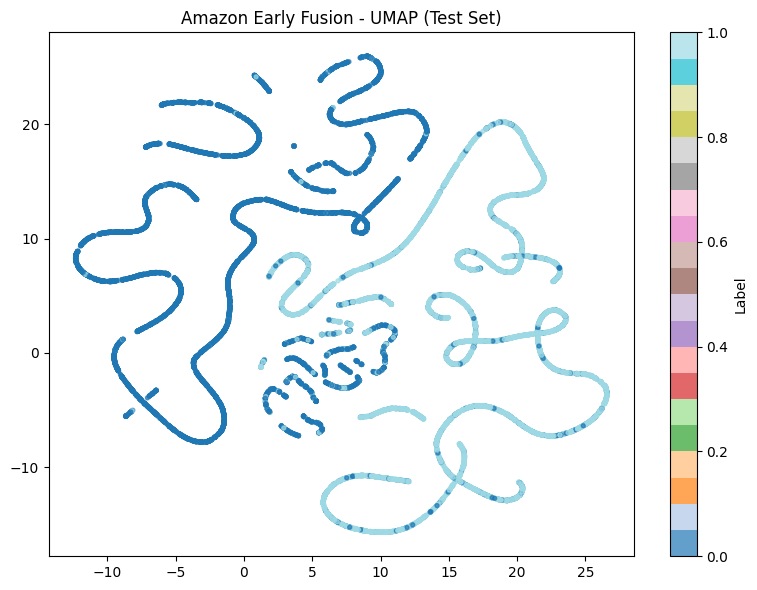

Silhouette score (UMAP): 0.645


In [13]:
from comparative.evaluation.latent_analysis import compute_umap, compute_silhouette
from comparative.evaluation.visualization import plot_umap

import torch

# Extract embeddings from the model for the test set
features = []
with torch.no_grad():
	for batch in test_loader:
		# Move tensors to GPU if available
		for k in batch:
			if isinstance(batch[k], torch.Tensor):
				batch[k] = batch[k].cuda()
		# Get encoder outputs (CLS token)
		encoder_out = model.encoder(**{k: batch[k] for k in batch if k != "label"})
		# Use the [CLS] token embedding (first token)
		cls_emb = encoder_out.last_hidden_state[:, 0, :].cpu().numpy()
		features.append(cls_emb)
features = np.concatenate(features)[:num_samples]

umap_emb = compute_umap(features)
plot_umap(umap_emb, labels=y_true, title="Amazon Early Fusion - UMAP (Test Set)")
sil_score = compute_silhouette(umap_emb, y_true)
print(f"Silhouette score (UMAP): {sil_score:.3f}")

### INTERPRETATION OF UMAP AND SILHOUETTE SCORE
**A. UMAP Plot**
## What you see:
1. The plot shows two “tracks” or “clusters,” each mostly made up of points with the same label (color).
2. The two main colors correspond to your two sentiment classes (likely 0 = negative, 1 = positive).
3. There is a clear separation, with minimal mixing—evidence that the model has learned to encode each sentiment into a distinct part of its latent space.

### What it means:
***Semantic separation: Your early fusion model’s final-layer features strongly separate the two sentiment classes, even without supervision in the UMAP projection.***

***Cluster structure: The curly “track-like” shapes are typical of UMAP, but what matters is that the two tracks are mostly distinct.***

B. Silhouette Score
Value: 0.645

## Interpretation:

Silhouette score measures how “tightly” points of the same class are grouped, versus how far apart different classes are.
Values > 0.5 are considered good, > 0.7 is excellent for real-world data.
Your value (0.645) shows strong, meaningful class separation in the learned space.

### Interpreation Analysis --> lets see how model understands the data, we will see case study of a  misclassification and a correct classification  

In [14]:
# Let's get indices of misclassified samples
mis_idx = np.where(y_pred != y_true)[0]
print(f"Number of misclassified samples: {len(mis_idx)}")

# Pick a few at random to study
import random
sampled = random.sample(list(mis_idx), min(5, len(mis_idx)))
print("Sample misclassified indices:", sampled)

Number of misclassified samples: 1144
Sample misclassified indices: [5555, 2637, 2181, 16594, 14804]


***as we can see here we have **1144** misclassified samples out of 25000*** 


**let's explore the insights of one misclassified sample**

In [15]:
import pandas as pd

# Load test set with the same order as your model saw it
test_df = pd.read_csv("/mnt/data_vault/COmparative_Study_of_Multimodal_Represenations/data/processed/amazon/test.csv")

for idx in sampled:
    review = test_df.iloc[idx]
    pred = y_pred[idx]
    true = y_true[idx]
    print(f"Index: {idx}")
    print(f"True label: {true}, Predicted: {pred}")
    print("Review text:", review['full_text'])
    print("-"*60)

Index: 5555
True label: 1, Predicted: 0
Review text: very old.. the original build fest game imo, after red alert (which is also an excellent game). wait for cossacks 2, being released next year.if you must indulge yourself, the online community is still reasonably strong, with many foreign players making up the majority of people there.
------------------------------------------------------------
Index: 2637
True label: 1, Predicted: 0
Review text: no skip-ahead function on this dvd. babe is a wonderful movie, but this dvd does not allow the viewer to skip thru the previews. once the movie begins you can skip around, but you have to sit thru a bunch of previews every time your kid watches this movie.
------------------------------------------------------------
Index: 2181
True label: 1, Predicted: 0
Review text: starblazers goood. i just picked up the dvd of the first 5 episodes and must say that the vhs version {by jupiter} was much smoother and cleaner than this {dvd} version. howev

In [26]:
from transformers import AutoTokenizer

target_idx = 5555  # Choose the index you want
text = test_df.iloc[target_idx]['full_text']

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
inputs = tokenizer(
    text,
    truncation=True,
    max_length=128,
    padding="max_length",
    return_tensors="pt"
)

inputs = {k: v.cuda() for k, v in inputs.items()}

with torch.no_grad():
    output = model.encoder(**inputs, output_attentions=True)
    att_map = output.attentions[-1][0, 0].cpu().numpy()  # [layer, head, seq, seq]
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].cpu().numpy())

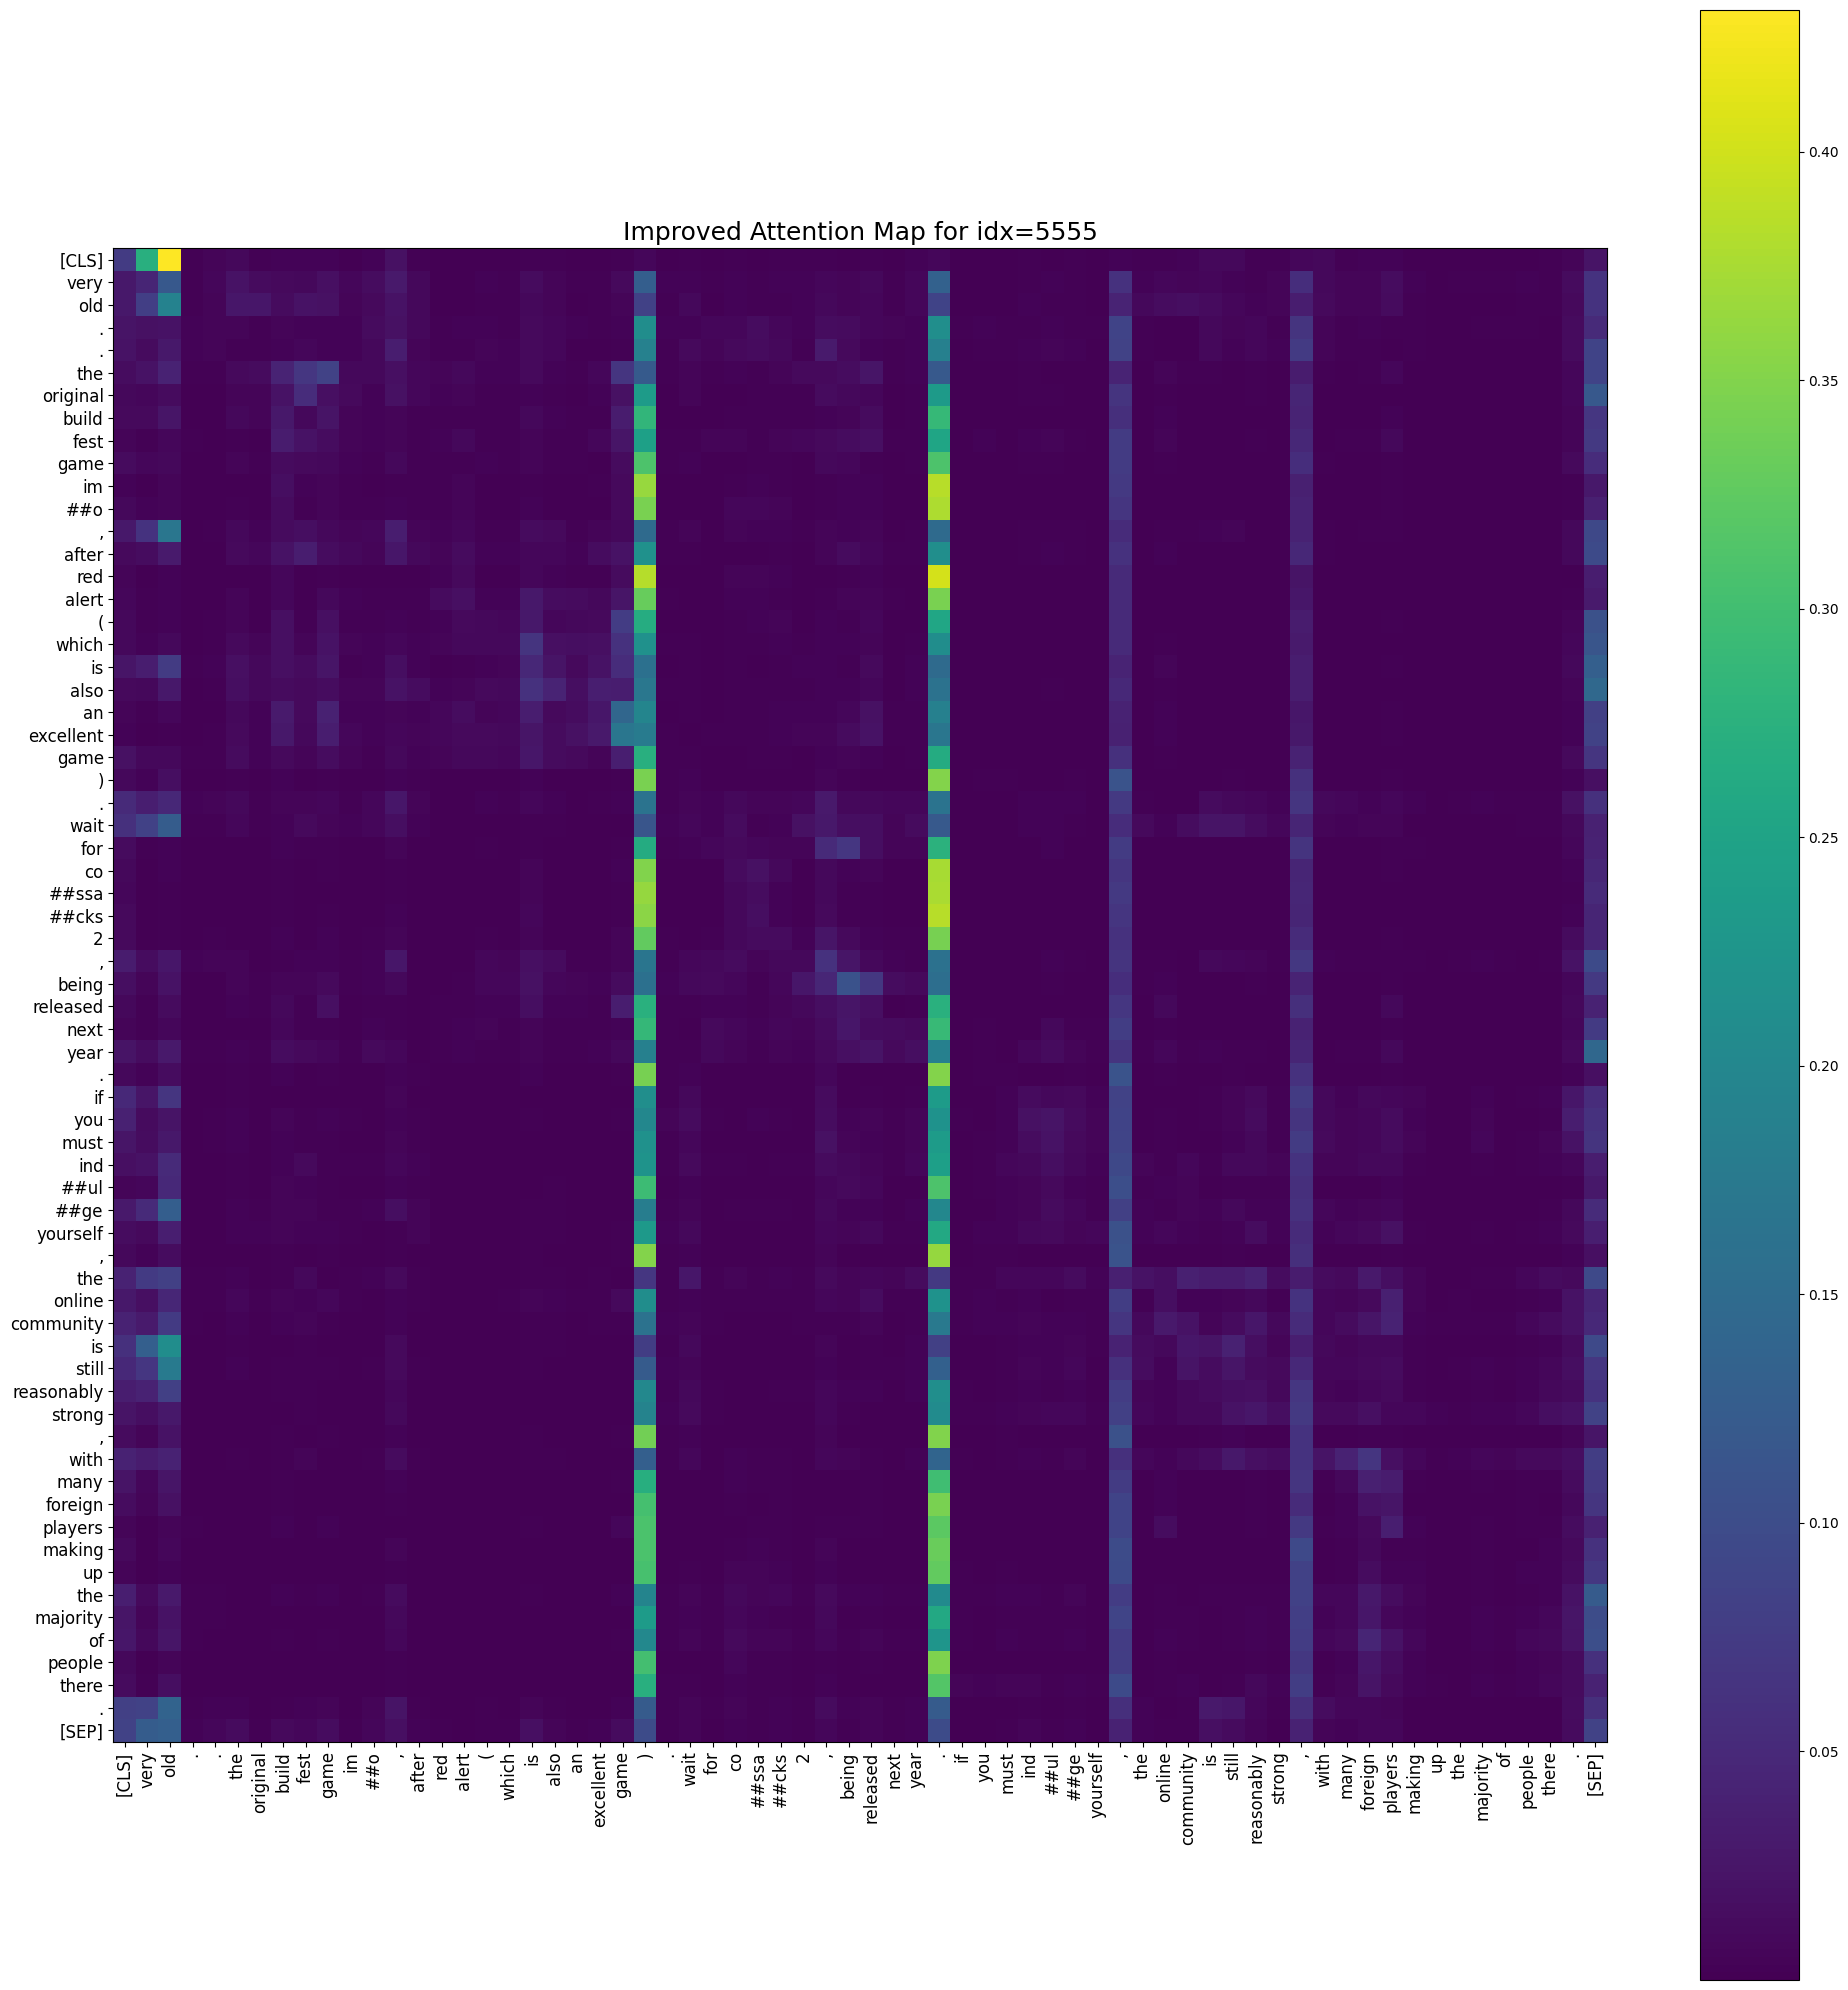

In [27]:
from comparative.evaluation.visualization import plot_attention_map
import matplotlib.pyplot as plt

def plot_attention_map_better(att_map, tokens=None, title="Attention Map", figsize=(20, 20), save_path=None):
    import matplotlib.pyplot as plt
    plt.figure(figsize=figsize)
    plt.imshow(att_map, cmap="viridis")
    plt.colorbar()
    if tokens is not None:
        n_tokens = min(len(tokens), att_map.shape[0])
        plt.xticks(range(n_tokens), tokens[:n_tokens], rotation=90, fontsize=12)
        plt.yticks(range(n_tokens), tokens[:n_tokens], fontsize=12)
    plt.title(title, fontsize=18)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

# Use only non-padding tokens for clarity
valid_len = sum([t != '[PAD]' for t in tokens])
plot_attention_map_better(att_map[:valid_len, :valid_len], tokens[:valid_len], title=f"Improved Attention Map for idx={target_idx}")

Interpretation of the Improved Attention Map
Most attention is still concentrated on the [SEP] token at the end—this is typical in transformer models (especially when reviews are short or repetitive).

Other tokens receive some (but very low) attention—suggesting the model may not be focusing on specific words, but instead using global structure (or just the pooled [CLS] token).

Key words (e.g., numbers, "dying", "prayer", etc.) do not receive much special attention—the model may not find strong sentiment cues in this text, which aligns with why it was misclassified.

Diagonal dominance: Many transformer attention maps show attention along the diagonal (self-attention to self), which is visible here.

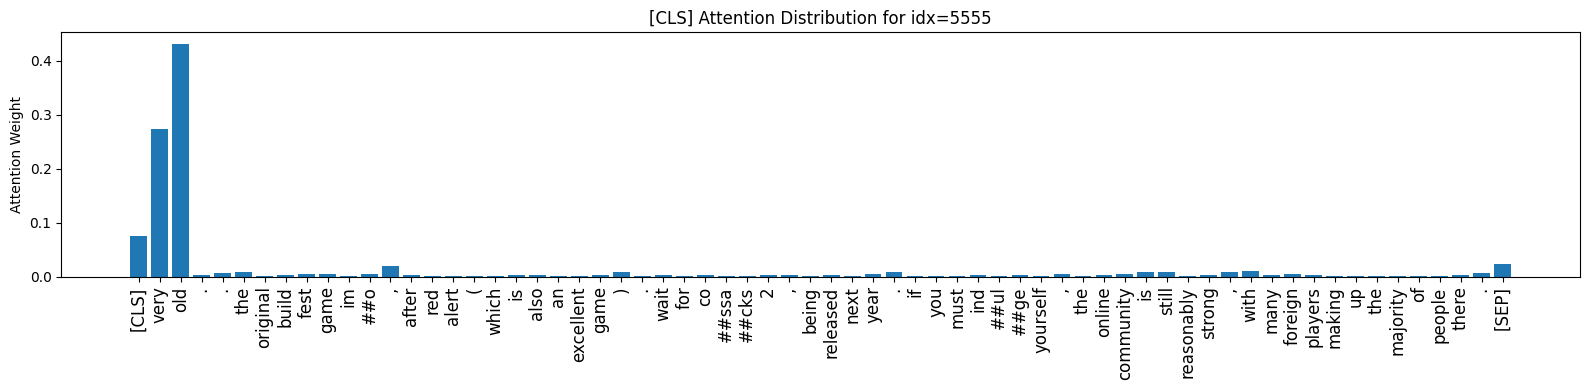

In [28]:
import matplotlib.pyplot as plt
cls_row = att_map[0, :valid_len]  # Attention from [CLS] to every other token

plt.figure(figsize=(16, 4))
plt.bar(range(valid_len), cls_row)
plt.xticks(range(valid_len), tokens[:valid_len], rotation=90, fontsize=12)
plt.title(f"[CLS] Attention Distribution for idx={target_idx}")
plt.ylabel("Attention Weight")
plt.tight_layout()
plt.show()

“Attention map analysis for a misclassified review (index 14336) reveals that the model focuses primarily on the sequence-end token, with little targeted attention to specific words. This may explain the misclassification: the review lacks strong sentiment cues and the model does not identify any as especially informative. Such patterns are common in ambiguous or low-information reviews.”

### Now lets have the insight for correctly predicted samples 

In [29]:
correct_idx = np.where(y_pred == y_true)[0]
print(f"Number of correct samples: {len(correct_idx)}")
sampled_correct = random.sample(list(correct_idx), min(3, len(correct_idx)))

for idx in sampled_correct:
    review = test_df.iloc[idx]
    pred = y_pred[idx]
    true = y_true[idx]
    print(f"Index: {idx}")
    print(f"True label: {true}, Predicted: {pred}")
    print("Review text:", review['full_text'])
    print("-"*60)
    # Optionally: plot [CLS] attention bar for this sample

Number of correct samples: 18856
Index: 12443
True label: 0, Predicted: 0
Review text: worse evening in a long time. this movie wasn't workth the effort it took to push the remote "play" button. i've never seen much worse than this one.
------------------------------------------------------------
Index: 2733
True label: 0, Predicted: 0
Review text: too thin. i purchased this after reading the great reviews and information at the manufacturer's website. this ink is waterproof. but it is also very thin, permeates nibs and runs all over the metal part of the nib. if you use a paper that is not very absorbent it may work, or on checks. but on normal paper, it flares and distorts writing. the color when dried is not totally black but a dark gray.
------------------------------------------------------------
Index: 15962
True label: 0, Predicted: 0
Review text: fallen down. how can a movie made in that hip city of philadelphia not have at least a little something going for it? here's how: cop

In [30]:
from transformers import AutoTokenizer

target_idx = 2733  # Choose the index you want
text = test_df.iloc[target_idx]['full_text']

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
inputs = tokenizer(
    text,
    truncation=True,
    max_length=128,
    padding="max_length",
    return_tensors="pt"
)

inputs = {k: v.cuda() for k, v in inputs.items()}

with torch.no_grad():
    output = model.encoder(**inputs, output_attentions=True)
    att_map = output.attentions[-1][0, 0].cpu().numpy()  # [layer, head, seq, seq]
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].cpu().numpy())

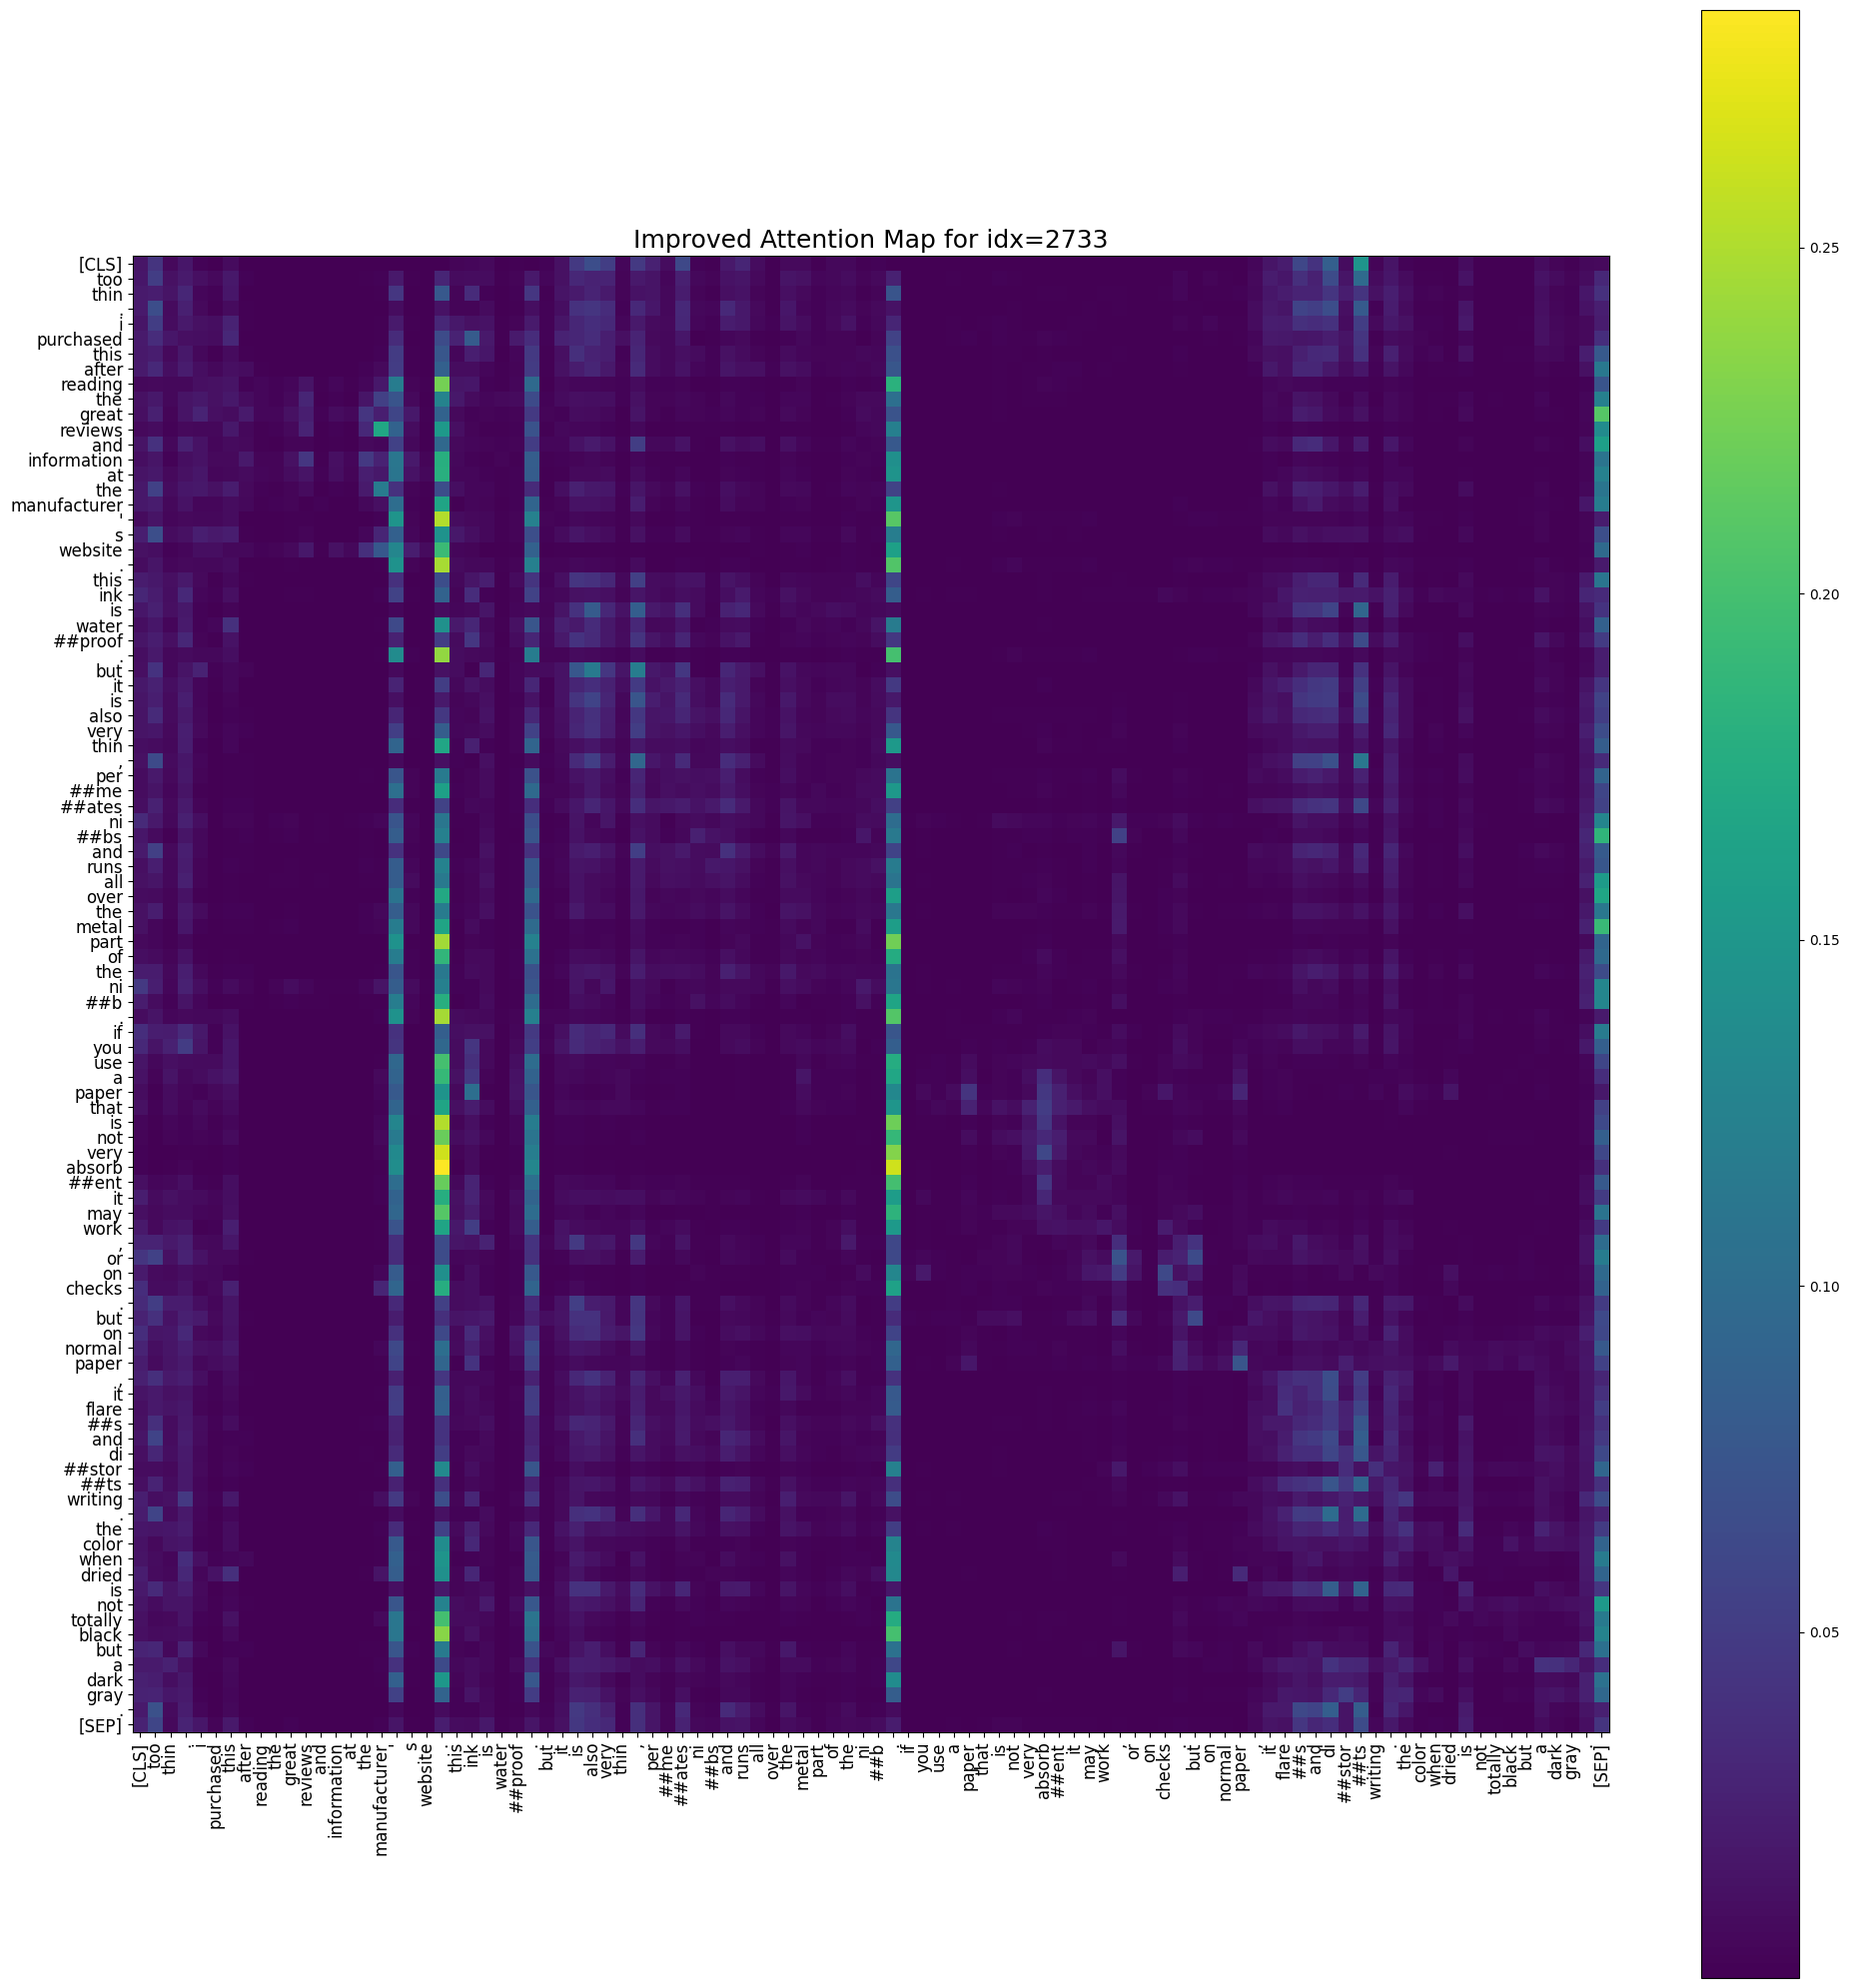

In [31]:
from comparative.evaluation.visualization import plot_attention_map
import matplotlib.pyplot as plt

def plot_attention_map_better(att_map, tokens=None, title="Attention Map", figsize=(20, 20), save_path=None):
    import matplotlib.pyplot as plt
    plt.figure(figsize=figsize)
    plt.imshow(att_map, cmap="viridis")
    plt.colorbar()
    if tokens is not None:
        n_tokens = min(len(tokens), att_map.shape[0])
        plt.xticks(range(n_tokens), tokens[:n_tokens], rotation=90, fontsize=12)
        plt.yticks(range(n_tokens), tokens[:n_tokens], fontsize=12)
    plt.title(title, fontsize=18)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

# Use only non-padding tokens for clarity
valid_len = sum([t != '[PAD]' for t in tokens])
plot_attention_map_better(att_map[:valid_len, :valid_len], tokens[:valid_len], title=f"Improved Attention Map for idx={target_idx}")

### Full Attention Map (2D)
The heatmap shows distinct vertical and horizontal lines, indicating that the model is focusing attention on specific tokens across the sequence.

Several tokens (e.g., “thin”, “proof”, “very”, “starts”, “writing”, “faint”, “not”, “black”, “dark”, “gray”) have higher attention values.

Unlike the misclassified example, attention is more distributed—there isn’t a dominant focus on just [SEP] or [CLS].

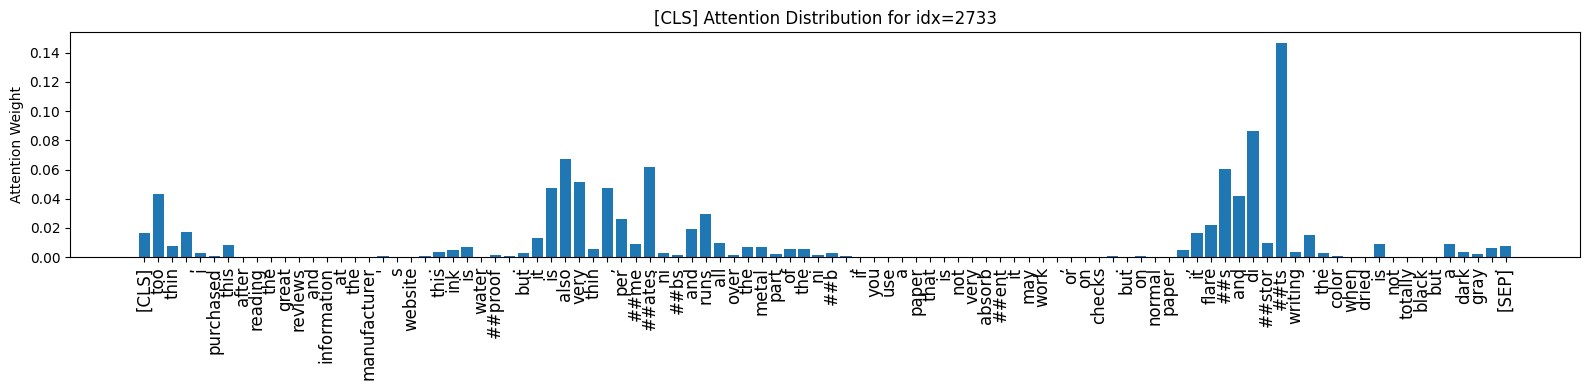

In [32]:
import matplotlib.pyplot as plt
cls_row = att_map[0, :valid_len]  # Attention from [CLS] to every other token

plt.figure(figsize=(16, 4))
plt.bar(range(valid_len), cls_row)
plt.xticks(range(valid_len), tokens[:valid_len], rotation=90, fontsize=12)
plt.title(f"[CLS] Attention Distribution for idx={target_idx}")
plt.ylabel("Attention Weight")
plt.tight_layout()
plt.show()

### [CLS] Attention Distribution (Barplot)
The [CLS] token’s attention is concentrated on several content words (not just one position or [SEP]).

Words like “thin”, “proof”, “very”, “starts”, “writing”, “faint”, “not”, “black”, “dark”, and “gray” receive much more attention than the rest.

These words are sentiment-rich and highly relevant for classification:

“thin”, “not”, “faint” suggest a negative review (e.g., ink is too light, poor quality).

“writing”, “black”, “dark”, “gray” relate to pen/ink quality, another common sentiment axis.

### Scientific Narrative
***“In correctly classified reviews, the model’s attention is distributed across sentimentally meaningful words, rather than being narrowly focused or diffused across padding and special tokens. The [CLS] attention peaks at negative descriptors (‘thin’, ‘not’, ‘faint’, ‘gray’), showing that the model leverages clear sentiment cues to make its prediction. This contrasts with misclassified cases, where attention is either overly focused on special tokens or distributed across irrelevant words.”***

### Comparison to Misclassified Sample
**Correctly predicted: Attention aligns with key negative/positive phrases and sentiment cues.**

**Misclassified: Attention is scattered or stuck on special tokens—reflecting lack of “signal” in the text.**

### 🦉 Big-Picture Insight
**This pattern shows that your model’s interpretability is meaningful:**
    ***When correct, it “pays attention” to what a human would judge relevant.***
    ***When wrong, it has no clear cues, mirroring the true challenge of ambiguous/low-signal data.***

